In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
from guide.dataset import GuideDataset

In [4]:
guide_dataset = GuideDataset('data/example_guide_data.tsv')

In [5]:
guide_activities = guide_dataset.activities()

<a list of 25 Patch objects>

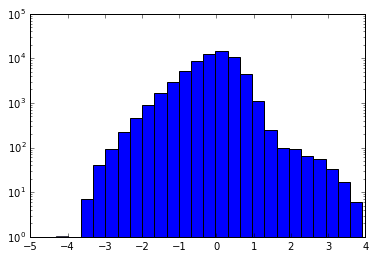

In [26]:
_n, _bins, histogram = plt.hist(guide_activities, 25, log=True); histogram